In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
from datetime import datetime, timedelta


In [2]:
import numpy as np
import pandas as pd
import datetime as dt


# Reflect Tables into SQLAlchemy ORM

In [23]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func
from sqlalchemy import create_engine, text
from sqlalchemy import create_engine, inspect
from datetime import datetime, timedelta

In [19]:
# Create engine using the `hawaii.sqlite` database file
engine = create_engine("sqlite:///Resources/hawaii.sqlite")


In [20]:
# Declare a Base using `automap_base()`
Base = automap_base()

# Use the Base class to reflect the database tables
Base.prepare(engine, reflect=True)

C:\Users\Mary Du\AppData\Local\Temp\ipykernel_10836\3555078317.py:5: SADeprecationWarning: The AutomapBase.prepare.reflect parameter is deprecated and will be removed in a future release.  Reflection is enabled when AutomapBase.prepare.autoload_with is passed.
  Base.prepare(engine, reflect=True)


In [21]:
# Print all of the classes mapped to the Base
print(Base.classes.keys())

['measurement', 'station']


In [25]:
inspector = inspect(engine)
inspector.get_table_names()


['measurement', 'station']

In [28]:
# Get a list of column names and types
columns = inspector.get_columns('measurement')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [9]:
# Assign the measurement class to a variable called `Measurement` and
# assign the station class to a variable called `Station`
Measurement = Base.classes.measurement
Station = Base.classes.station

In [10]:
# Create a session
session = Session(engine)

# Exploratory Precipitation Analysis

In [11]:
# Find the most recent date in the data set.
most_recent_date = session.query(func.max(Measurement.date)).scalar()
print(most_recent_date)

2017-08-23


Text(32.45833333333333, 0.5, 'mm')


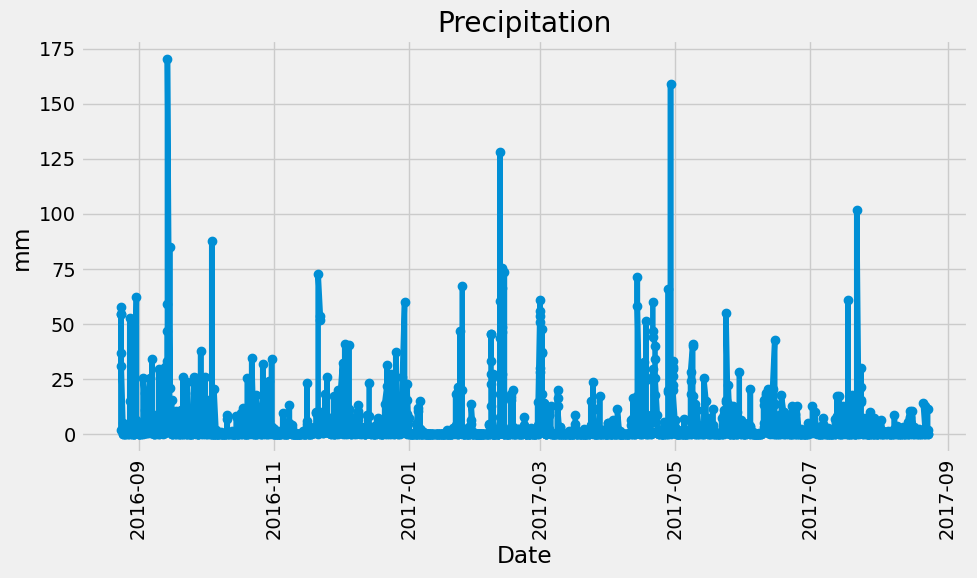

In [33]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results.
# Starting from the most recent data point in the database.

# Calculate the date one year before the most recent date
start_date = most_recent_date - timedelta(days=365)

# Query to retrieve the last 12 months of precipitation data
query = session.query(Measurement.date, Measurement.prcp).filter(
    Measurement.date >= start_date
).order_by(Measurement.date).all()

# Convert the query results to a list of tuples
data = [(date, prcp) for date, prcp in query]

# Create a DataFrame from the query results
df = pd.DataFrame(data, columns=['Date', 'Precipitation'])

# Convert the 'Date' column to datetime
df['Date'] = pd.to_datetime(df['Date'])

df = df.sort_values(by='Date')

# Plot the data
plt.figure(figsize=(10, 6))
plt.plot(df['Date'], df['Precipitation'], marker='o', linestyle='-')
plt.xlabel('Date')
plt.ylabel('mm')
plt.title('Precipitation')
plt.grid(True)
plt.xticks(rotation=90)
plt.tight_layout()

ylabel = plt.ylabel('mm')
print(ylabel)

# Show the plot
plt.show()


In [34]:
# Use Pandas to calculate the summary statistics for the precipitation data
summary_statistics = df['Precipitation'].describe()

summary_statistics

count    2015.000000
mean        4.485112
std        11.690532
min         0.000000
25%         0.000000
50%         0.500000
75%         3.300000
max       170.200000
Name: Precipitation, dtype: float64

# Exploratory Station Analysis

In [35]:
# Design a query to calculate the total number of stations in the dataset
total_stations = session.query(func.count().filter(Station.station.in_(session.query(Station.station).distinct()))).scalar()
print([(total_stations,)])

[(9,)]


In [36]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
results = session.query(Measurement.station, func.count().label('count')) \
    .group_by(Measurement.station) \
    .order_by(func.count().desc()) \
    .all()

# Print the stations and their counts
# List the stations and their counts in descending order.
for station, count in results:
    print(f"{station}, {count}")

USC00519281, 2772
USC00519397, 2724
USC00513117, 2709
USC00519523, 2669
USC00516128, 2612
USC00514830, 2202
USC00511918, 1979
USC00517948, 1372
USC00518838, 511


In [37]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
results = session.query(Measurement.station, func.count().label('count')) \
    .group_by(Measurement.station) \
    .order_by(func.count().desc()) \
    .first()  # Get the most active station

most_active_station = results.station

# Query to calculate the lowest, highest, and average temperature for the most active station
temperature_stats = session.query(
    func.min(Measurement.tobs).label('min_temp'),
    func.max(Measurement.tobs).label('max_temp'),
    func.avg(Measurement.tobs).label('avg_temp')
).filter(Measurement.station == most_active_station).all()

# Print the temperature statistics
min_temp, max_temp, avg_temp = temperature_stats[0]
print([(temperature_stats)])

[[(12.2, 29.4, 22.03582251082252)]]


Start Date: 2016-08-23
End Date: 2017-08-23
Text(0.5, 0, 'Temperature')


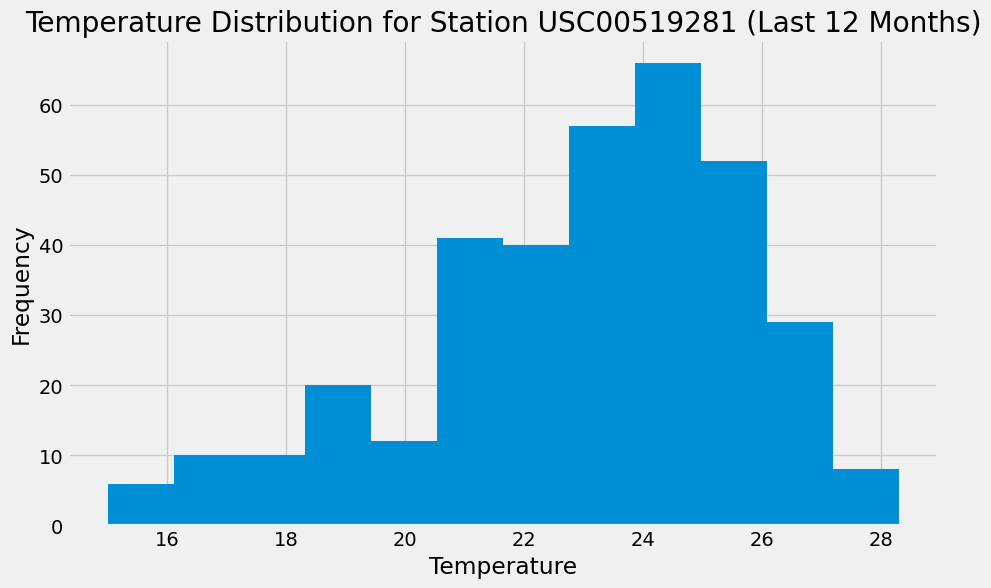

In [38]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

# Start date for the query
end_date = datetime.strptime('2017/8/23', '%Y/%m/%d')
start_date = end_date - timedelta(days=365)

# Convert to string format if needed for SQL queries
start_date_str = start_date.strftime('%Y-%m-%d')
end_date_str = end_date.strftime('%Y-%m-%d')

print(f"Start Date: {start_date_str}")
print(f"End Date: {end_date_str}")

# Query the last 12 months of temperature data for the most active station
temperature_data = session.query(Measurement.tobs) \
    .filter(Measurement.station == most_active_station) \
    .filter(Measurement.date >= start_date) \
    .filter(Measurement.date <= end_date) \
    .all()

# Extract temperatures from the query result
temperatures = [temp[0] for temp in temperature_data]
temperatures

# Plot the histogram
plt.figure(figsize=(10, 6))
plt.hist(temperatures, bins=12, edgecolor=None)
plt.title(f"Temperature Distribution for Station {most_active_station} (Last 12 Months)")
plt.xlabel('Temperature')
plt.ylabel('Frequency')
plt.grid(True)

xlabel = plt.xlabel('Temperature')
print(xlabel)

plt.show()



# Close Session

In [39]:
# Close Session
session.close()
